In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('RSCCASN.csv',parse_dates=True, index_col='DATE')

In [3]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

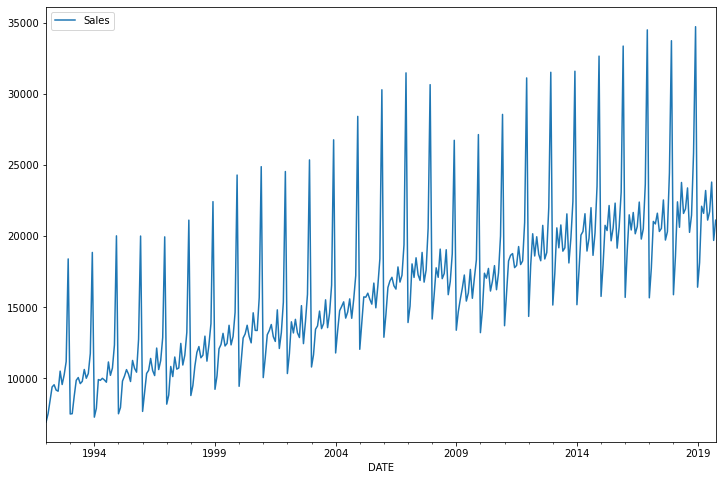

In [5]:
df.plot(figsize=(12,8))

In [6]:
len(df)

334

In [7]:
len(df)-18

316

In [8]:
test_size = 18
test_index = len(df)-test_size

In [9]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [10]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaled_train = scaler.fit_transform(train)

In [14]:
scaled_test = scaler.transform(test)

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
len(test)

18

In [17]:
length = 12      #this length should be less than the test data
generator = TimeseriesGenerator(scaled_train,scaled_train,
                                length=length, batch_size=1)

In [18]:
X,y = generator[0]

In [19]:
#len(X[0])

In [20]:
#y

In [21]:
from tensorflow.keras.models import Sequential

In [22]:
from tensorflow.keras.layers import Dense, LSTM

In [23]:
n_feature=1

In [24]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape=(length,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [27]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [28]:
model.fit_generator(generator, epochs=20, 
                    validation_data=validation_generator,
                   callbacks=[early_stopping])

C:\Users\Piyush Dewangan\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 2s 4ms/step - loss: 0.0264 - val_loss: 0.0033
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0032
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0105
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0095


In [29]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

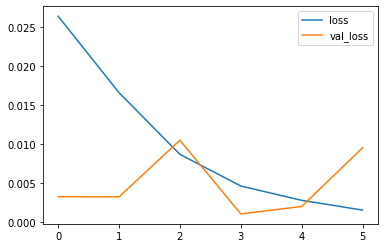

In [30]:
losses.plot()

In [31]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_feature))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)  

In [32]:
true_pred=scaler.inverse_transform(test_predictions)

In [33]:
test['True_pred'] = true_pred

<ipython-input-33-d4eab287451a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['True_pred'] = true_pred


<AxesSubplot:xlabel='DATE'>

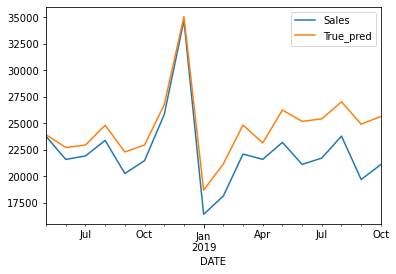

In [34]:
test.plot()

In [35]:
full_scaler = MinMaxScaler()

In [36]:
scaled_full_data=full_scaler.fit_transform(df)

In [37]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length, batch_size=1)

In [40]:
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=6)

C:\Users\Piyush Dewangan\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
322/322 [==============================] - 5s 8ms/step - loss: 0.0253
Epoch 2/6
322/322 [==============================] - 2s 6ms/step - loss: 0.0183
Epoch 3/6
322/322 [==============================] - 2s 7ms/step - loss: 0.0144
Epoch 4/6
322/322 [==============================] - 2s 7ms/step - loss: 0.0065
Epoch 5/6
322/322 [==============================] - 2s 7ms/step - loss: 0.0040
Epoch 6/6
322/322 [==============================] - 2s 7ms/step - loss: 0.0034


In [41]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_feature))

for i in range(12):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)  

In [42]:
forecast = scaler.inverse_transform(forecast)

In [44]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [43]:
forecast

array([[25805.41022062],
       [34515.66244888],
       [17221.78044963],
       [18894.90873861],
       [22065.23863411],
       [21705.4671073 ],
       [23037.94123125],
       [21372.87147379],
       [21934.50441313],
       [23617.29686546],
       [20429.95022774],
       [21735.35681391]])

In [45]:
forecast_index = pd.date_range(start='2019-11-01', periods=12,freq="MS")

In [47]:
print(forecast_index)

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')


In [49]:
forecast_df = pd.DataFrame(data=forecast , index=forecast_index,
                          columns=['forecast'])

In [50]:
forecast_df

,forecast
2019-11-01,25805.410221
2019-12-01,34515.662449
2020-01-01,17221.780450
2020-02-01,18894.908739
2020-03-01,22065.238634
2020-04-01,21705.467107
2020-05-01,23037.941231
2020-06-01,21372.871474
2020-07-01,21934.504413
2020-08-01,23617.296865


<AxesSubplot:xlabel='DATE'>

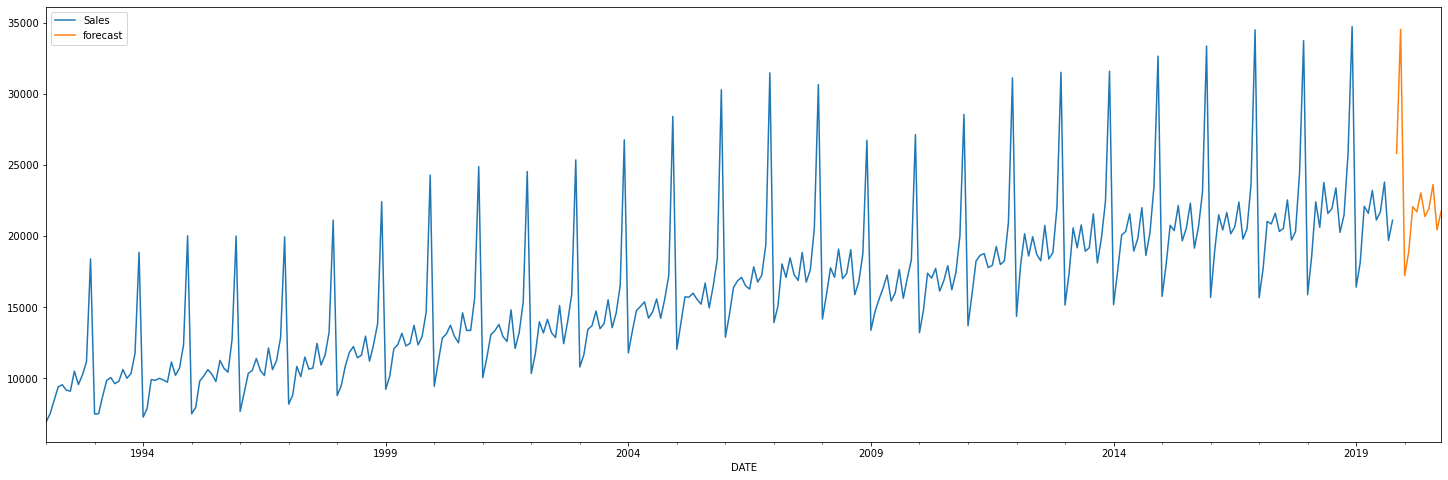

In [56]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(25,8))

(576.0, 611.0)

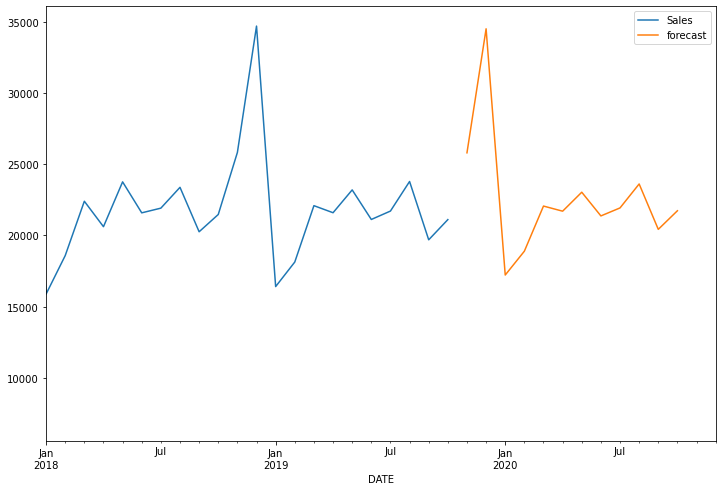

In [59]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,8))
plt.xlim('2018-01-01','2020-12-01')